In [2]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
batch_size = 8
train_path = 'datasets/imagenette2/train'
val_path =  'datasets/imagenette2/val'
train_dataloader = torch.utils.data.DataLoader(datasets.ImageFolder(train_path, 
                                                                   transform = transforms.Compose([
                                                                        transforms.RandomResizedCrop(224),
                                                                        transforms.RandomHorizontalFlip(),
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                             std=[0.229, 0.224, 0.225])
                                                                   ])), batch_size = batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(datasets.ImageFolder(val_path,
                                                               transform=transforms.Compose([
                                                                   transforms.ToTensor(),
                                                                   transforms.Resize([224, 224]),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std=[0.229, 0.224, 0.225])
                                                               ])),batch_size=batch_size, shuffle=True)

In [5]:
classes = ['tench', 'springer', 'casette_player', 'chain_saw','church', 'French_horn', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute']

In [6]:
%run models.ipynb
%run utils.ipynb

# Normal Model

In [8]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_imagenette.pth"
model_save_path = model_path / model_name
model_normal = resnet_18(filter='None', filter_layer=0)
model_normal.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [9]:
# Model to GPU and eval mode.
model_normal.to(device)
model_normal.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_normal, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 81.43%


In [10]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

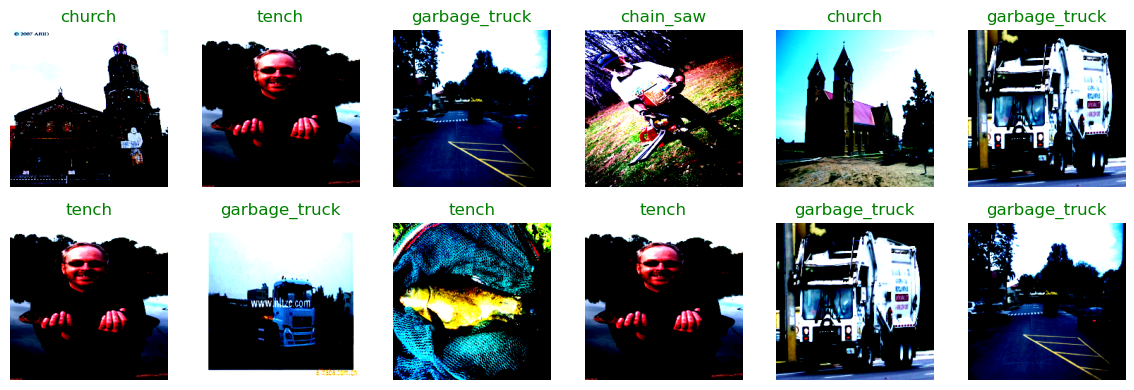

In [11]:
# See random images with their labels
# torch.manual_seed(42)  # setting random seed
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))
indexes=[]
rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    img, label_gt = x_batch[random_idx], y_batch[random_idx]
    indexes.append(random_idx)
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model_normal(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    
    plt.imshow(img.cpu().numpy(), cmap='gray')
    if label_pred == label_gt:
        plt.title(classes[label_pred], color='g') # for correct prediction
    else:
        plt.title(classes[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();
plt.show()

In [14]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [15]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_normal).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_normal).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_normal)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

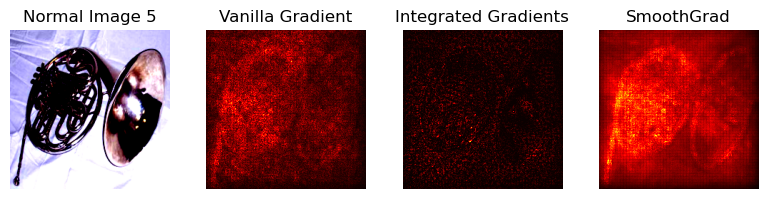

In [706]:
index = indexes[2]
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_normal')

# No tune L1

In [710]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_imagenette_no_tuned_l1.pth"
model_save_path = model_path / model_name
model_no_tuned_l1 = resnet_18(filter='None', filter_layer=0)

for name, module in model_no_tuned_l1.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"Resnet L1 Unstructured sparsity = {compute_sparsity_resnet(model_no_tuned_l1):.2f}%")

model_no_tuned_l1.load_state_dict(torch.load(model_save_path))

Resnet L1 Unstructured sparsity = 19.99%


<All keys matched successfully>

In [711]:
# Model to GPU and eval mode.
model_no_tuned_l1.to(device)
model_no_tuned_l1.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_l1, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 77.91%


In [713]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [714]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_l1).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_l1).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_l1)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

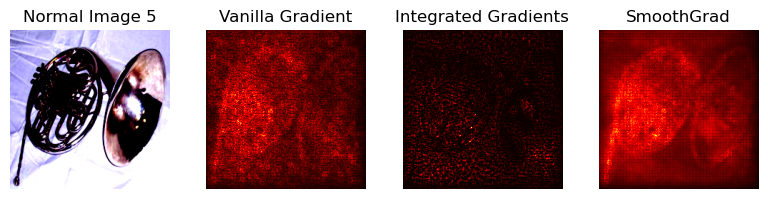

In [715]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_no_tuned_l1')

# Tune L1

In [717]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_imagenette_post_tuned_l1.pth"
model_save_path = model_path / model_name
model_post_tuned_l1 = resnet_18(filter='None', filter_layer=0)

for name, module in model_post_tuned_l1.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"Resnet L1 Unstructured sparsity = {compute_sparsity_resnet(model_post_tuned_l1):.2f}%")

model_post_tuned_l1.load_state_dict(torch.load(model_save_path))

Resnet L1 Unstructured sparsity = 19.99%


<All keys matched successfully>

In [718]:
# Model to GPU and eval mode.
model_post_tuned_l1.to(device)
model_post_tuned_l1.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_l1, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 83.08%


In [719]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [720]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_l1).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_l1).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_l1)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

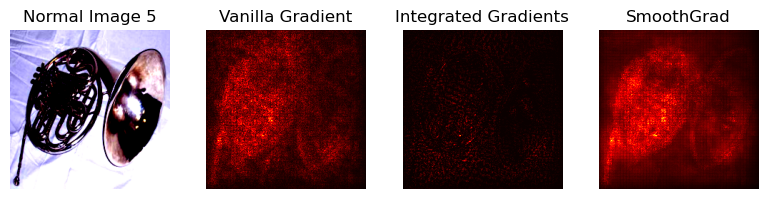

In [721]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_post_tuned_l1')

# No tune Global

In [723]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_imagenette_no_tuned_global.pth"
model_save_path = model_path / model_name
model_no_tuned_global = resnet_18(filter='None', filter_layer=0)

parameters_to_prune = (
    (model_no_tuned_global.conv1, 'weight'),
    (model_no_tuned_global.bn1, 'weight'),
    (model_no_tuned_global.layer1[0].conv1, 'weight'),
    (model_no_tuned_global.layer1[0].bn1, 'weight'),
    (model_no_tuned_global.layer1[0].conv2, 'weight'),
    (model_no_tuned_global.layer1[0].bn2, 'weight'),
    (model_no_tuned_global.layer1[1].conv1, 'weight'),
    (model_no_tuned_global.layer1[1].bn1, 'weight'),
    (model_no_tuned_global.layer1[1].conv2, 'weight'),
    (model_no_tuned_global.layer1[1].bn2, 'weight'),
    (model_no_tuned_global.layer2[0].conv1, 'weight'),
    (model_no_tuned_global.layer2[0].bn1, 'weight'),
    (model_no_tuned_global.layer2[0].conv2, 'weight'),
    (model_no_tuned_global.layer2[0].bn2, 'weight'),
    (model_no_tuned_global.layer2[1].conv1, 'weight'),
    (model_no_tuned_global.layer2[1].bn1, 'weight'),
    (model_no_tuned_global.layer2[1].conv2, 'weight'),
    (model_no_tuned_global.layer2[1].bn2, 'weight'),
    (model_no_tuned_global.layer3[0].conv1, 'weight'),
    (model_no_tuned_global.layer3[0].bn1, 'weight'),
    (model_no_tuned_global.layer3[0].conv2, 'weight'),
    (model_no_tuned_global.layer3[0].bn2, 'weight'),
    (model_no_tuned_global.layer3[1].conv1, 'weight'),
    (model_no_tuned_global.layer3[1].bn1, 'weight'),
    (model_no_tuned_global.layer3[1].conv2, 'weight'),
    (model_no_tuned_global.layer3[1].bn2, 'weight'),
    (model_no_tuned_global.layer4[0].conv1, 'weight'),
    (model_no_tuned_global.layer4[0].bn1, 'weight'),
    (model_no_tuned_global.layer4[0].conv2, 'weight'),
    (model_no_tuned_global.layer4[0].bn2, 'weight'),
    (model_no_tuned_global.layer4[1].conv1, 'weight'),
    (model_no_tuned_global.layer4[1].bn1, 'weight'),
    (model_no_tuned_global.layer4[1].conv2, 'weight'),
    (model_no_tuned_global.layer4[1].bn2, 'weight'),
    (model_no_tuned_global.fc, 'weight')
)

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"RESNET-18 global sparsity = {compute_sparsity_resnet(model_no_tuned_global):.2f}%")

model_no_tuned_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
RESNET-18 global sparsity = 20.00%


<All keys matched successfully>

In [724]:
# Model to GPU and eval mode.
model_no_tuned_global.to(device)
model_no_tuned_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_global, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 81.07%


In [725]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [726]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_global)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

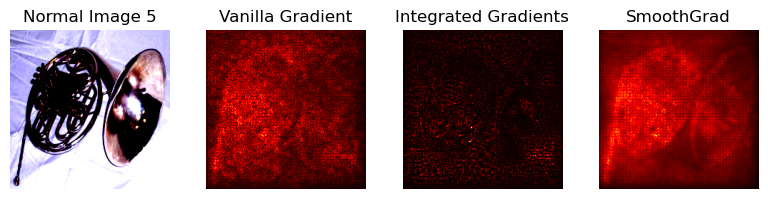

In [727]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_no_tuned_global')

# Tuned Global

In [729]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_imagenette_post_tuned_global.pth"
model_save_path = model_path / model_name
model_post_tuned_global = resnet_18(filter='None', filter_layer=0)

parameters_to_prune = (
    (model_post_tuned_global.conv1, 'weight'),
    (model_post_tuned_global.bn1, 'weight'),
    (model_post_tuned_global.layer1[0].conv1, 'weight'),
    (model_post_tuned_global.layer1[0].bn1, 'weight'),
    (model_post_tuned_global.layer1[0].conv2, 'weight'),
    (model_post_tuned_global.layer1[0].bn2, 'weight'),
    (model_post_tuned_global.layer1[1].conv1, 'weight'),
    (model_post_tuned_global.layer1[1].bn1, 'weight'),
    (model_post_tuned_global.layer1[1].conv2, 'weight'),
    (model_post_tuned_global.layer1[1].bn2, 'weight'),
    (model_post_tuned_global.layer2[0].conv1, 'weight'),
    (model_post_tuned_global.layer2[0].bn1, 'weight'),
    (model_post_tuned_global.layer2[0].conv2, 'weight'),
    (model_post_tuned_global.layer2[0].bn2, 'weight'),
    (model_post_tuned_global.layer2[1].conv1, 'weight'),
    (model_post_tuned_global.layer2[1].bn1, 'weight'),
    (model_post_tuned_global.layer2[1].conv2, 'weight'),
    (model_post_tuned_global.layer2[1].bn2, 'weight'),
    (model_post_tuned_global.layer3[0].conv1, 'weight'),
    (model_post_tuned_global.layer3[0].bn1, 'weight'),
    (model_post_tuned_global.layer3[0].conv2, 'weight'),
    (model_post_tuned_global.layer3[0].bn2, 'weight'),
    (model_post_tuned_global.layer3[1].conv1, 'weight'),
    (model_post_tuned_global.layer3[1].bn1, 'weight'),
    (model_post_tuned_global.layer3[1].conv2, 'weight'),
    (model_post_tuned_global.layer3[1].bn2, 'weight'),
    (model_post_tuned_global.layer4[0].conv1, 'weight'),
    (model_post_tuned_global.layer4[0].bn1, 'weight'),
    (model_post_tuned_global.layer4[0].conv2, 'weight'),
    (model_post_tuned_global.layer4[0].bn2, 'weight'),
    (model_post_tuned_global.layer4[1].conv1, 'weight'),
    (model_post_tuned_global.layer4[1].bn1, 'weight'),
    (model_post_tuned_global.layer4[1].conv2, 'weight'),
    (model_post_tuned_global.layer4[1].bn2, 'weight'),
    (model_post_tuned_global.fc, 'weight')
)

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"RESNET-18 global sparsity = {compute_sparsity_resnet(model_post_tuned_global):.2f}%")

model_post_tuned_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
RESNET-18 global sparsity = 20.00%


<All keys matched successfully>

In [730]:
# Model to GPU and eval mode.
model_post_tuned_global.to(device)
model_post_tuned_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_global, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 86.80%


In [731]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [732]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_global)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

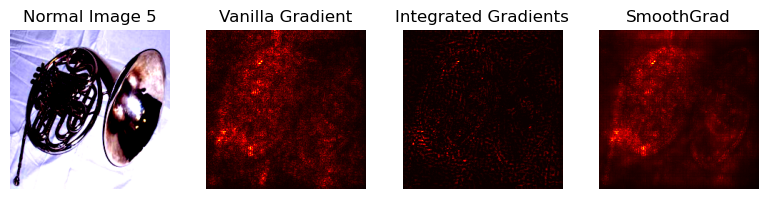

In [733]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_post_tuned_global')

# No tune Layered

In [735]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_imagenette_no_tuned_layered.pth"
model_save_path = model_path / model_name
model_no_tuned_layered = resnet_18(filter='None', filter_layer=0)

 # Prune layer-wise in a structured manner-
prune.ln_structured(model_no_tuned_layered.conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer1[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer1[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer1[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer1[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer2[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer2[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer2[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer2[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer3[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer3[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer3[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer3[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer4[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer4[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer4[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer4[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)

prune.ln_structured(model_no_tuned_layered.fc, name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"Resnet structrured sparsity = {compute_sparsity_resnet(model_no_tuned_layered):.2f}%")

model_no_tuned_layered.load_state_dict(torch.load(model_save_path))

Resnet structrured sparsity = 9.99%


<All keys matched successfully>

In [736]:
# Model to GPU and eval mode.
model_no_tuned_layered.to(device)
model_no_tuned_layered.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_layered, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 20.00%


In [737]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [738]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_layered).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_layered).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_layered)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

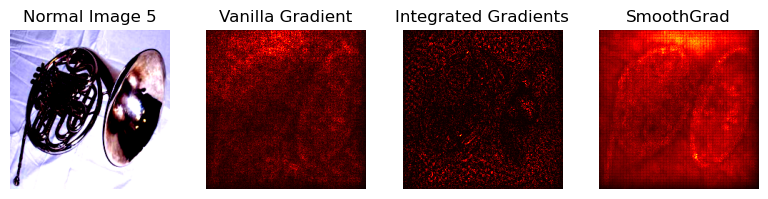

In [739]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_no_tuned_layered')

# Tuned Layered

In [764]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_imagenette_post_tuned_layered.pth"
model_save_path = model_path / model_name
model_post_tuned_layered = resnet_18(filter='None', filter_layer=0)

 # Prune layer-wise in a structured manner-
prune.ln_structured(model_post_tuned_layered.conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer1[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer1[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer1[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer1[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer2[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer2[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer2[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer2[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer3[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer3[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer3[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer3[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer4[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer4[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer4[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer4[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)

prune.ln_structured(model_post_tuned_layered.fc, name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"Resnet structrured sparsity = {compute_sparsity_resnet(model_post_tuned_layered):.2f}%")

model_post_tuned_layered.load_state_dict(torch.load(model_save_path))

Resnet structrured sparsity = 9.99%


<All keys matched successfully>

In [766]:
# Model to GPU and eval mode.
model_post_tuned_layered.to(device)
model_post_tuned_layered.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_layered, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 83.72%


In [767]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [768]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_layered).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_layered).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_layered)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

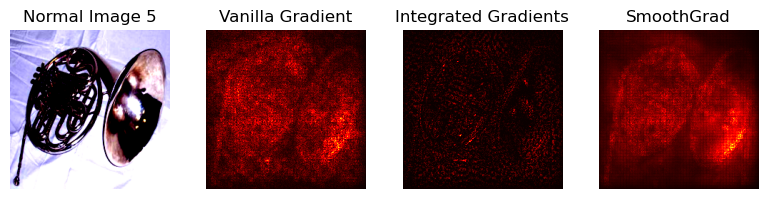

In [769]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_post_tuned_layered')

# Quantitative Metrics

In [25]:
def explainer_wrapper(**kwargs):
    """
    A wrapper function to call the appropriate explanation method.

    """
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")



def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    """
    Generate explanations for a model's predictions using the SmoothGrad method.

    Args:
        model: The model to explain.
        inputs : Input samples.
        targets: Target labels corresponding to the inputs.
        abs : Whether to use the absolute value of gradients.
        normalise: Whether to normalize the explanation
        stdevs: Standard deviation of the noise added to inputs
        nt_samples: Number of noisy samples to generate for SmoothGrad.

    Returns:
        numpy.ndarray: Explanation maps for the input samples.
    """
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 224),kwargs.get("img_size", 224),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        )
    saliency = Saliency(model)
    
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation




In [26]:
xai_method=["SmoothGrad"]
gc.collect()
torch.cuda.empty_cache()

In [48]:
result_normal = {1: np.float64(0.985176916001797), 11: np.float64(0.9406093297550283), 21: np.float64(0.9028416916773444), 31: np.float64(0.8543888427383359), 41: np.float64(0.8032685215056397), 51: np.float64(0.7248614888432506), 61: np.float64(0.6479488612398864), 71: np.float64(0.5500896125038881), 81: np.float64(0.4410576002823054), 91: np.float64(0.3104449764341038)}

result_no_tuned_l1 ={1: np.float64(0.9820607361879746), 11: np.float64(0.9191253925934467), 21: np.float64(0.873725968929225), 31: np.float64(0.8178349404762254), 41: np.float64(0.7533730664522551), 51: np.float64(0.6760264628304135), 61: np.float64(0.5918752430512368), 71: np.float64(0.5026545201933624), 81: np.float64(0.40752498411672305), 91: np.float64(0.2941542335272096)}

result_post_tuned_l1 = {1: np.float64(0.9856601695393404), 11: np.float64(0.9308630805089735), 21: np.float64(0.8838323050563219), 31: np.float64(0.8212838433462287), 41: np.float64(0.7503039130846376), 51: np.float64(0.6607468519940162), 61: np.float64(0.5685317960260906), 71: np.float64(0.47511420924145176), 81: np.float64(0.37182787950643614), 91: np.float64(0.2894524046127858)}

result_no_tuned_global = {1: np.float64(0.9825522786789018), 11: np.float64(0.9230067030508784), 21: np.float64(0.8740872905556647), 31: np.float64(0.8227141190153604), 41: np.float64(0.7589837096594783), 51: np.float64(0.685046422646815), 61: np.float64(0.6109797948903499), 71: np.float64(0.523163250083316), 81: np.float64(0.4211236423349825), 91: np.float64(0.2977510730357213)}

result_post_tuned_global = {1: np.float64(0.9801956871112462), 11: np.float64(0.9185493051753286), 21: np.float64(0.86252875867225), 31: np.float64(0.8030384627650594), 41: np.float64(0.7273281753913854), 51: np.float64(0.6511514376100891), 61: np.float64(0.5645524660686533), 71: np.float64(0.4732577826400438), 81: np.float64(0.38727077013589645), 91: np.float64(0.2869559462705041)}

result_post_tuned_layered = {1: np.float64(0.9825238944616163), 11: np.float64(0.9212016633104406), 21: np.float64(0.867465178517329), 31: np.float64(0.80304539178882), 41: np.float64(0.747116657533766), 51: np.float64(0.6709419133874174), 61: np.float64(0.580958787092246), 71: np.float64(0.49016306363292833), 81: np.float64(0.3835216466857461), 91: np.float64(0.2810177919470063)}





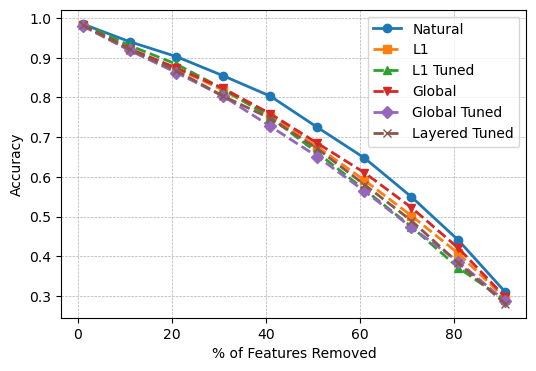

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='x', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/RESNET_IMAGENET_SALIENCY_ROAD_POST.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [53]:
result_normal = {1: np.float64(0.9257102415047268), 11: np.float64(0.6766015765478892), 21: np.float64(0.5901847546904095), 31: np.float64(0.5407112960138988), 41: np.float64(0.5162772459190045), 51: np.float64(0.512049005677952), 61: np.float64(0.509658068671806), 71: np.float64(0.5038507957933503), 81: np.float64(0.4776769190594899), 91: np.float64(0.4319758313274273)}
result_no_tuned_l1 = {1: np.float64(0.9121461161616443), 11: np.float64(0.6495516671233736), 21: np.float64(0.5528320324702423), 31: np.float64(0.4982023165486788), 41: np.float64(0.47388574392886135), 51: np.float64(0.4685954644098595), 61: np.float64(0.46788209910532214), 71: np.float64(0.45408112774432924), 81: np.float64(0.4223029720868901), 91: np.float64(0.3820343910032469)}

result_post_tuned_l1 = {1: np.float64(0.9351513687699352), 11: np.float64(0.688867045851771), 21: np.float64(0.5978369715613309), 31: np.float64(0.54769378057587), 41: np.float64(0.5203217208943497), 51: np.float64(0.5057600447087465), 61: np.float64(0.49928938304806886), 71: np.float64(0.4824644158521989), 81: np.float64(0.447010061268917), 91: np.float64(0.3963520622297266)}

result_no_tuned_global = {1: np.float64(0.9175731903904998), 11: np.float64(0.659894720102311), 21: np.float64(0.563788998759821), 31: np.float64(0.5109760419837935), 41: np.float64(0.4809984350279226), 51: np.float64(0.47901862127560896), 61: np.float64(0.4754536833413558), 71: np.float64(0.4662933909091028), 81: np.float64(0.44212085954759905), 91: np.float64(0.3999526812984485)}

result_post_tuned_global = {1: np.float64(0.9282193520598641), 11: np.float64(0.695982757518206), 21: np.float64(0.6209437896576858), 31: np.float64(0.5676107828429778), 41: np.float64(0.5421179919407892), 51: np.float64(0.5274395122989213), 61: np.float64(0.5108166879197281), 71: np.float64(0.49455128399219445), 81: np.float64(0.4523587861670446), 91: np.float64(0.393007108866225)}

result_post_tuned_layered = {1: np.float64(0.9278319934111215), 11: np.float64(0.7070790481061849), 21: np.float64(0.6193428584156061), 31: np.float64(0.5646970010218706), 41: np.float64(0.5337164399976323), 51: np.float64(0.5027385378941217), 61: np.float64(0.4744856735045431), 71: np.float64(0.43657514031516714), 81: np.float64(0.40057438103442056), 91: np.float64(0.3502089980598628)}

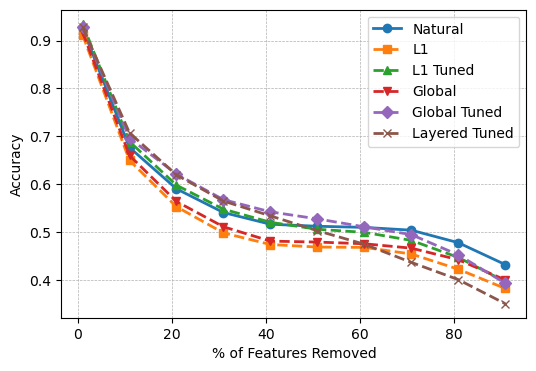

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='x', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/RESNET_IMAGENET_IG_SALIENCY_ROAD_POST.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [57]:
result_normal = {1: np.float64(0.9834333959517533), 11: np.float64(0.9164847770366226), 21: np.float64(0.8397299449012687), 31: np.float64(0.765307818924537), 41: np.float64(0.681550711696633), 51: np.float64(0.5876534123916588), 61: np.float64(0.4931000950104948), 71: np.float64(0.4067143119295172), 81: np.float64(0.31780654378464146), 91: np.float64(0.2284064479197357)}
result_no_tuned_l1 = {1: np.float64(0.9730188655022974), 11: np.float64(0.8946090143461142), 21: np.float64(0.8172297419532832), 31: np.float64(0.7347606892005302), 41: np.float64(0.6494591280128847), 51: np.float64(0.5543473701456307), 61: np.float64(0.4544781665319537), 71: np.float64(0.3639624406199418), 81: np.float64(0.2866844186780359), 91: np.float64(0.21041042714303457)}

result_post_tuned_l1 ={1: np.float64(0.9818188497460799), 11: np.float64(0.9040893548110769), 21: np.float64(0.8249263573993963), 31: np.float64(0.7408736103744713), 41: np.float64(0.6467615270912418), 51: np.float64(0.5437955487937175), 61: np.float64(0.45615341933710835), 71: np.float64(0.3696132117236035), 81: np.float64(0.29003646845386877), 91: np.float64(0.22096354819690445)}

result_no_tuned_global = {1: np.float64(0.9803403953995533), 11: np.float64(0.8956477537270195), 21: np.float64(0.8207771562457498), 31: np.float64(0.7338140634511164), 41: np.float64(0.6384974390548657), 51: np.float64(0.5532224579759236), 61: np.float64(0.4658975900428535), 71: np.float64(0.3615957199339696), 81: np.float64(0.29266775172365345), 91: np.float64(0.22487934296769493)}

result_post_tuned_global = {1: np.float64(0.978507954449902), 11: np.float64(0.8942301714559904), 21: np.float64(0.8260054759982656), 31: np.float64(0.7440484831325418), 41: np.float64(0.6584787528084795), 51: np.float64(0.5825432821880399), 61: np.float64(0.49591334900462714), 71: np.float64(0.4071344365238272), 81: np.float64(0.30601627209643945), 91: np.float64(0.2185497815780089)}

result_post_tuned_layered ={1: np.float64(0.9810602708276707), 11: np.float64(0.9052093412112788), 21: np.float64(0.8368895408609676), 31: np.float64(0.7697002981503457), 41: np.float64(0.6968567058007255), 51: np.float64(0.6034932548870188), 61: np.float64(0.5130574383895633), 71: np.float64(0.40033843828034527), 81: np.float64(0.3127224783323126), 91: np.float64(0.21977963058522543)}


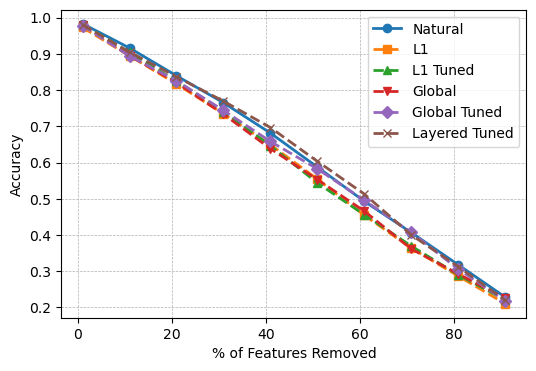

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='x', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/RESNET_IMAGENET_SMOOTH_SALIENCY_ROAD_POST.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# Input Stability

In [66]:
normal_input_saliency = -0.9018778769075133
normal_input_ig = 1.7639805688893246
normal_input_smooth = -1.944678350030911

no_l1_input_saliency =-0.9565710073375766
no_l1_input_ig = 1.6816224034317266
no_l1_input_smooth =  -1.9679651648355145

l1_input_saliency = -1.0833400672882196
l1_input_ig =  1.8929032293026353
l1_input_smooth = -1.953954165759128

no_global_input_saliency =  -0.9048504607108367
no_global_input_ig = 1.9523044635736881
no_global_input_smooth = -1.9511881673079379

global_input_saliency =  -1.0596753677445678
global_input_ig = 1.5982602237784
global_input_smooth = -1.8588608612563278

layered_input_saliency = -1.0180510481394605
layered_input_ig = 1.7137371157923815
layered_input_smooth = -1.982070279670087

In [70]:
vanilla_gradient = [normal_input_saliency, no_l1_input_saliency, l1_input_saliency, no_global_input_saliency, global_input_saliency, layered_input_saliency]
integrated_gradients = [normal_input_ig, no_l1_input_ig, l1_input_ig,no_global_input_ig, global_input_ig, layered_input_ig]
smoothgrad = [normal_input_smooth, no_l1_input_smooth, l1_input_smooth, no_global_input_smooth,global_input_smooth, layered_input_smooth]

row_labels = ["Normal Model", "L1 Untuned Model", "L1 Unstructured Tuned", "Global Untuned","Global Tuned", "Layered Structured Tuned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,-0.901878,1.763981,-1.944678
L1 Untuned Model,-0.956571,1.681622,-1.967965
L1 Unstructured Tuned,-1.083340,1.892903,-1.953954
Global Untuned,-0.904850,1.952304,-1.951188
Global Tuned,-1.059675,1.598260,-1.858861
Layered Structured Tuned,-1.018051,1.713737,-1.982070


# Output Metric

In [95]:
normal_input_saliency =2.599161006047119
normal_input_ig = 5.38499484348373
normal_input_smooth =  1.7481519399002996

no_l1_input_saliency =2.6181387105369267
no_l1_input_ig =  5.4489499266747385
no_l1_input_smooth =   1.7627798754270951

l1_input_saliency =  2.6079193384205115
l1_input_ig =   5.498679264580991
l1_input_smooth = 1.806686403909221

no_global_input_saliency =  2.579434137974502
no_global_input_ig =  5.3583009754471
no_global_input_smooth = 1.7366142492280643

global_input_saliency =   2.9164156976295685
global_input_ig =  6.29560589885126
global_input_smooth =  2.257026843815427

layered_input_saliency = 2.4827715181766994
layered_input_ig =  5.413595297917731
layered_input_smooth = 1.6909724549684688

In [97]:
vanilla_gradient = [normal_input_saliency, no_l1_input_saliency, l1_input_saliency, no_global_input_saliency, global_input_saliency, layered_input_saliency]
integrated_gradients = [normal_input_ig, no_l1_input_ig, l1_input_ig,no_global_input_ig, global_input_ig, layered_input_ig]
smoothgrad = [normal_input_smooth, no_l1_input_smooth, l1_input_smooth, no_global_input_smooth,global_input_smooth, layered_input_smooth]

row_labels = ["Normal Model", "L1 Untuned Model", "L1 Unstructured Tuned", "Global Untuned","Global Tuned", "Layered Structured Tuned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,2.599161,5.384995,1.748152
L1 Untuned Model,2.618139,5.448950,1.762780
L1 Unstructured Tuned,2.607919,5.498679,1.806686
Global Untuned,2.579434,5.358301,1.736614
Global Tuned,2.916416,6.295606,2.257027
Layered Structured Tuned,2.482772,5.413595,1.690972


# Sparsity

In [89]:
normal_input_saliency =0.39796420125163795
normal_input_ig =0.5671080835443905
normal_input_smooth =  0.3147218970987349

no_l1_input_saliency =0.3871666425945166
no_l1_input_ig = 0.5633101608919656
no_l1_input_smooth =  0.3064489330135361

l1_input_saliency =  0.42758235210577683
l1_input_ig =  0.5812099256312531
l1_input_smooth = 0.3542669643446185

no_global_input_saliency = 0.3900692576606439
no_global_input_ig = 0.5644230854149549
no_global_input_smooth = 0.30947061312726876

global_input_saliency =   0.488467265553319
global_input_ig =   0.6185110395520088
global_input_smooth =  0.4123022448254427

layered_input_saliency =0.3782773424042649
layered_input_ig =  0.514149203582438
layered_input_smooth = 0.30972299174275314

In [92]:
vanilla_gradient = [normal_input_saliency, no_l1_input_saliency, l1_input_saliency, no_global_input_saliency, global_input_saliency, layered_input_saliency]
integrated_gradients = [normal_input_ig, no_l1_input_ig, l1_input_ig,no_global_input_ig, global_input_ig, layered_input_ig]
smoothgrad = [normal_input_smooth, no_l1_input_smooth, l1_input_smooth, no_global_input_smooth,global_input_smooth, layered_input_smooth]

row_labels = ["Normal Model", "L1 Untuned Model", "L1 Unstructured Tuned", "Global Untuned","Global Tuned", "Layered Structured Tuned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,0.397964,0.567108,0.314722
L1 Untuned Model,0.387167,0.563310,0.306449
L1 Unstructured Tuned,0.427582,0.581210,0.354267
Global Untuned,0.390069,0.564423,0.309471
Global Tuned,0.488467,0.618511,0.412302
Layered Structured Tuned,0.378277,0.514149,0.309723
